In [3]:
import sys
print(sys.version)

3.5.2 |Anaconda custom (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]


In [133]:
import numpy as np
import matplotlib
import scipy as sp
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import mdtraj as md
from mdtraj.utils import ensure_type
#%matplotlib inline
%matplotlib notebook

In [145]:
print("NumPy version: {}".format(np.__version__))
print("SciPy version: {}".format(sp.__version__))
print("Mdtraj version: {}".format(md.version.version))
print("Matplotlib version: {}".format(matplotlib.__version__))

NumPy version: 1.11.1
SciPy version: 0.18.0
Mdtraj version: 1.7.2
Matplotlib version: 1.5.1


## Function definitions

Concerning the functions "center_of_mass, _distance, _reduce_box_vectors, _distance_mic, and compute_distances" I use a modified version of the functions of the mdtraj package. The functions have been adapted in order to calculate the distances between the center of mass of the droplet and a selection of atoms. (In the mdtraj package, it is only possible to use these functions between 2 pairs of atoms).

In [6]:
def smooth(x,window_len=11,window='hanning'):
    """
    The code comes from: http://wiki.scipy.org/Cookbook/SignalSmooth
    
    smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
        flat window will produce a moving average smoothing.
       
    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    """
    
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len)
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len//2-1):-(window_len//2)]

In [127]:
def plot(data, dt = 10, xlabel='r $[nm]$', ylabel='g(r)', fontsize=30, x_max = 15, output='rdf.pdf'):
    """
    plot data.
    data:
            np.array
            first column: time [ns]
            next columns: data (==rdfs)
    dt: integer
        number of values that are skipped
    xlabel : string
    ylabel : string
    fontsize: integer
    x_max = integer
            x limit for plotting
    output: string (pdf, jpg, ...)
            name of the output file to save the plot
    """
    fig = plt.figure(figsize=(11,8))
    ax = fig.add_subplot(1, 1, 1)
    
    # DATA
    ax.plot(data[0, ::dt], data[1,::dt], '-', linewidth=3.0, label='1')
    ax.plot(data[0, ::dt], data[2,::dt], '-', linewidth=3.0, label='1')
    ax.plot(data[0, ::dt], data[3,::dt], '-', linewidth=3.0, label='1')
    ax.plot(data[0, ::dt], data[4,::dt], '-', linewidth=3.0, label='1')
    
    # Legend
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.legend(['TO', 'CO', 'POPC', 'POPE'], fontsize=fontsize-5, loc='best')
    
    # police
    ax.tick_params(labelsize=fontsize)
    ax.set_xlim([0.0, x_max])
    # Add and specify different settings for minor grids
    ax.set_xticks(np.arange(0.0, x_max+1, 1.0), minor = True)
    ax.grid(which = 'major', alpha = 2)
    # Specify different settings for major and minor grids
    ax.grid(which = 'minor', alpha = 1)

    plt.tight_layout()
    fig.savefig(output)

##### center of mass

In [8]:
def center_of_mass(traj, residue_selection):
    """Compute the center of mass for each frame.

    Parameters
    ----------
    traj : Trajectory
        Trajectory to compute center of mass for
    residue_selection : str 
        Residue name

    Returns
    -------
    com : np.ndarray, shape=(n_frames, 3)
         Coordinates of the center of mass for each frame
    """

    com = np.zeros((traj.n_frames, 3))
    selection = [atom for atom in topology.atoms if str(atom)[:4] == residue_selection]
    masses = np.array([a.element.mass for a in selection])   #     traj.top.atoms])
    masses /= masses.sum()

    atom_indexes = [atom.index for atom in topology.atoms if str(atom)[:4] == residue_selection]
    for i, xyz in enumerate(traj.xyz[:, atom_indexes[0]:atom_indexes[-1]+1,:]):
        com[i, :] = xyz.astype('float64').T.dot(masses)
    return com

##### distance (without the minimum image convention)

In [9]:
def _distance(xyz, ref, selection):
    """Distance between a reference and the com in each frame
    
    Parameters
    ----------
    xyz : Trajectory
        An mtraj trajectory
    selection : int
        index of the atom
    ref : np.ndarray, shape=(len(traj), 3), dtype=float
        center of mass
    """
    return np.sum((ref[:, np.newaxis, :] - traj.xyz[:, selection])**2, -1)**0.5

##### distance (with the minimum image convention)

In [10]:
def _reduce_box_vectors(vectors):
    """Make sure box vectors are in reduced form."""
    (bv1, bv2, bv3) = vectors
    bv3 -= bv2*round(bv3[1]/bv2[1]);
    bv3 -= bv1*round(bv3[0]/bv1[0]);
    bv2 -= bv1*round(bv2[0]/bv1[0]);
    return (bv1, bv2, bv3)

def _distance_mic(xyz, com, selection, box_vectors, orthogonal):
    """Distance between pairs of points in each frame under the minimum image
    convention for periodic boundary conditions.

    The computation follows scheme B.9 in Tukerman, M. "Statistical
    Mechanics: Theory and Molecular Simulation", 2010.

    This is a slow pure python implementation, mostly for testing.
    """
    out = np.empty((xyz.shape[0], selection.shape[0]), dtype=np.float32)
    #out = np.empty((xyz.shape[0], pairs.shape[0]), dtype=np.float32)
    for i, a in zip(range(len(xyz)), com):
        bv1, bv2, bv3 = _reduce_box_vectors(box_vectors[i].T)

        for j, b in enumerate(selection):
        #for j, (a,b) in enumerate(pairs):
            r12 = a - xyz[i,b,:]
            #r12 = xyz[i,b,:] - xyz[i,a,:]
            r12 -= bv3*round(r12[2]/bv3[2]);
            r12 -= bv2*round(r12[1]/bv2[1]);
            r12 -= bv1*round(r12[0]/bv1[0]);
            dist = np.linalg.norm(r12)
            if not orthogonal:
                for ii in range(-1, 2):
                    v1 = bv1*ii
                    for jj in range(-1, 2):
                        v12 = bv2*jj + v1
                        for kk in range(-1, 2):
                            new_r12 = r12 + v12 + bv3*kk
                            dist = min(dist, np.linalg.norm(new_r12))
            out[i, j] = dist
    return out

In [11]:
def compute_distances(traj, com, selection, periodic=True, opt=False):
    """Compute the distances between com and atoms of selection in each frame.

    Parameters
    ----------
    traj : Trajectory
        An mtraj trajectory.
    com : np.ndarray, shape=(n_frames, 3), dtype=float
        Each row (=time frame) gives the coordinates of the center of mass
    selection : np.ndarray, shape=(atom_indexes, ), dtype=int
        Each row gives the indices of one atom.
    periodic : bool, default=True
        If `periodic` is True and the trajectory contains unitcell
        information, we will compute distances under the minimum image
        convention.
    opt : bool, default=False, not Implemented in this version
        Use an optimized native library to calculate distances. Our optimized
        SSE minimum image convention calculation implementation is over 1000x
        faster than the naive numpy implementation.

    Returns
    -------
    distances : np.ndarray, shape=(n_frames, num_atoms), dtype=float
        The distance, in each frame, between the COM and each atom of the selection.
    """
    xyz = ensure_type(traj.xyz, dtype=np.float32, ndim=3, name='traj.xyz', shape=(None, None, 3), warn_on_cast=False)
    atoms = ensure_type(selection, dtype=np.int32, ndim=1, name='selection', shape=(None, ), warn_on_cast=False)
    if not np.all(np.logical_and(atoms < traj.n_atoms, atoms >= 0)):
        raise ValueError('Selection must contain indices between 0 and %d' % traj.n_atoms)
    
    if len(atoms) == 0:
        raise ValueError('Selection is empty! You should select some atoms to calculate the distance with the COM.')
    
    if periodic and traj._have_unitcell:
        box = ensure_type(traj.unitcell_vectors, dtype=np.float32, ndim=3, name='unitcell_vectors', shape=(len(xyz), 3, 3),
                          warn_on_cast=False)
        orthogonal = np.allclose(traj.unitcell_angles, 90)
        #if opt:
        #    out = np.empty((xyz.shape[0], pairs.shape[0]), dtype=np.float32)
        #    _geometry._dist_mic(xyz, pairs, box.transpose(0, 2, 1).copy(), out, orthogonal)
        #    return out
        #else:
        return _distance_mic(xyz, com, selection, box.transpose(0, 2, 1), orthogonal)

    # either there are no unitcell vectors or they dont want to use them
    #if opt:
    #    out = np.empty((xyz.shape[0], pairs.shape[0]), dtype=np.float32)
    #    _geometry._dist(xyz, pairs, out)
    #    return out
    #else:
    return _distance(xyz, com, selection)

##### Radial Distribution Function

In [13]:
class PairDistributionFunction:
    def __init__(self, trajectory, center, atoms, bin_width = 0.005, upper_limit = 2.5, periodic=True):
        """
        Parameters
        ----------
        traj : Trajectory
               An mtraj trajectory.
        center : np.ndarray, shape=(n_frames, 3), dtype=float
            Each row (=time frame) gives the coordinates of the reference point (ex: center of mass)
        atoms : np.ndarray, shape=(atom_indexes, ), dtype=int
            Each row gives the index of one atom.
        bin_width : int, optional, default=0.005
                    Width of the bins in nanometer.
        upper_limit : float, default=2.5
                      Upper limit to calculate pair distribution function in nanometer.
        periodic : bool, default=True
                   If `periodic` is True and the trajectory contains unitcell
                   information, we will compute distances under the minimum image
                   convention.
        """
        self.traj = trajectory
        self.center = center
        self.atoms = atoms
        self.bin_width = bin_width
        self.upper_limit = upper_limit
        # verifying that the upper limit is less than half the size of the box
        assert self.upper_limit < (self.traj.unitcell_vectors[-1][0][0]/2.), "upper_limit is greater than half the size of the box, you should choose another value for upper_limit"
        
        # bins for histogram
        self.bins = np.arange(0, self.upper_limit, self.bin_width)
        
        # cell volume for each step - it is assumed that the box is cubic
        vol = []
        for frame in range(self.traj.n_frames):
            vol.append(np.power(self.traj.unitcell_vectors[frame][0][0], 3))
        cell_volume = np.array(vol)
        
        # density averaged over step
        self.density = len(atoms) / cell_volume
        self.density = self.density.mean()
        
        # distances betweem center and atoms
        atom_indexes = np.array(atoms)
        self.dist = compute_distances(self.traj, self.center, atom_indexes, periodic=periodic)
        #self.dist = _distance(self.traj, self.center, atom_indexes)
        
    def rdf(self):
        """
        Returns
        -------
        r : np.ndarray, dtype=float
            Radii values corresponding to the centers of the bins.
        pdf : np.ndarray, dtype=float
              Pair distribution function values at r.
        r_max : float
                radius corresponding to the maximum of the 1st peak.
        r_min : float
                radius corresponding to the minimum of the 1st peak.
        n_coord: float
                 coordination number around center for the first peak.
        note about r_min, r_max and n_coord: It is assumed that a maximum is encountered before the first minimum.
        """
        hist = np.histogram(self.dist[:self.traj.n_frames], self.bins)
        r = 0.5 * (hist[1][1:] + hist[1][:-1])
            
        # Volume bins
        volBin = 4./3. * np.pi * (hist[1][1:]**3 - hist[1][:-1]**3)
        
        # PDF
        pdf = hist[0] / (volBin * self.density) / self.traj.n_frames / len(self.center)
        
        # Minima and maxima radii of the first peak
        # PDFs can be very noisy, so as a first step, the pdf has to be smoothened
        # otherwise the next step would find the minima and maxima of the noise
        pdf_smooth = smooth(pdf)
        # local maxima
        pos_max = argrelextrema(pdf_smooth, np.greater, order=10, mode='wrap')
        # local minima
        pos_min = argrelextrema(pdf_smooth[pos_max[0][0]:], np.less, order=10, mode='wrap')
        # It is assumed that the first index correspond to a maximum and the second index to the minimum 
        # of the first peak
        r_index_max = pos_max[0][0]
        r_index_min = pos_min[0][0]+r_index_max
        r_max = r[r_index_max]
        r_min = r[r_index_min]
        
        # coordination number = average number of atoms around center within r_min
        n_coord = hist[0][:r_index_min].sum() / self.traj.n_frames / len(self.center)
        
        return r, pdf, r_max, r_min, n_coord

## Loading the trajectory

In [12]:
traj = md.load('../md_10000ns.xtc', top='../md_10000ns.gro')
traj

<mdtraj.Trajectory with 2001 frames, 218666 atoms, 152666 residues, and unitcells at 0x10f5d9c18>

In [25]:
topology = traj.topology

##### List of residues

In [66]:
import re
def charFilter(myString):
    return re.sub('[0-9]*', '', myString, 0)

In [68]:
res_names = {charFilter(str(res)) for res in topology.residues}
res_names

{'CO', 'POPC', 'POPE', 'TO', 'W', 'WF'}

In [14]:
res = 'POPC'
popc_atom_indexes = [atom.index for atom in topology.atoms if str(atom)[:len(res)] == res]
len(popc_atom_indexes)

20891

In [70]:
res = 'CO'
co_atom_indexes = [atom.index for atom in topology.atoms if str(atom)[:len(res)] == res]
len(co_atom_indexes)

11141

In [72]:
res = 'POPE'
pope_atom_indexes = [atom.index for atom in topology.atoms if str(atom)[:len(res)] == res]
len(pope_atom_indexes)

6968

In [73]:
res = 'TO'
to_atom_indexes = [atom.index for atom in topology.atoms if str(atom)[:len(res)] == res]
len(co_atom_indexes)

11141

In [74]:
com = center_of_mass(traj, 'POPC')

In [75]:
com.shape

(2001, 3)

### Test

Testing the distance algorithm:

In [24]:
diff = com[:, np.newaxis, :] - traj.xyz[:, popc_atom_indexes]
dist = np.sum(diff**2, -1)**0.5

dist2 = _distance(traj, com, popc_atom_indexes)
if np.array_equal(dist, dist2):
    print("test 1 OK.")

dist3 = compute_distances(traj, com, np.array(popc_atom_indexes), periodic = False)
if np.array_equal(dist, dist3):
    print("test 2 OK.")

dist4 = compute_distances(traj, com, np.array(popc_atom_indexes))
diff = dist4 - dist
if diff[diff>1e-6].size == 0:
    print("Test 3 OK.")

test 1 OK.
test 2 OK.
test3 OK.


## Compute the RDFs from the center of mass of the POPC residues (more or less equivalent to the center of mass of the droplet)

The compute_distance in the mdtraj library accepts only pairs of atoms. So I have to modify its behavior to allow the computation between the coordinates of the center of mass and another atom:

In [76]:
g = PairDistributionFunction(traj, com, popc_atom_indexes, upper_limit = 14.5, periodic=False)
g_com_popc = g.rdf()

In [77]:
g = PairDistributionFunction(traj, com, pope_atom_indexes, upper_limit = 14.5, periodic=False)
g_com_pope = g.rdf()

In [78]:
g = PairDistributionFunction(traj, com, co_atom_indexes, upper_limit = 14.5, periodic=False)
g_com_co = g.rdf()

In [79]:
g = PairDistributionFunction(traj, com, to_atom_indexes, upper_limit = 14.5, periodic=False)
g_com_to = g.rdf()

In [147]:
#plt.plot(g_com_popc[0], g_com_popc[1])

Stack arrays in sequence vertically:

In [110]:
rdfs = np.vstack((g_com_to[0], g_com_to[1], g_com_co[1], g_com_popc[1], g_com_pope[1]))
rdfs.shape

<IPython.core.display.Javascript object>


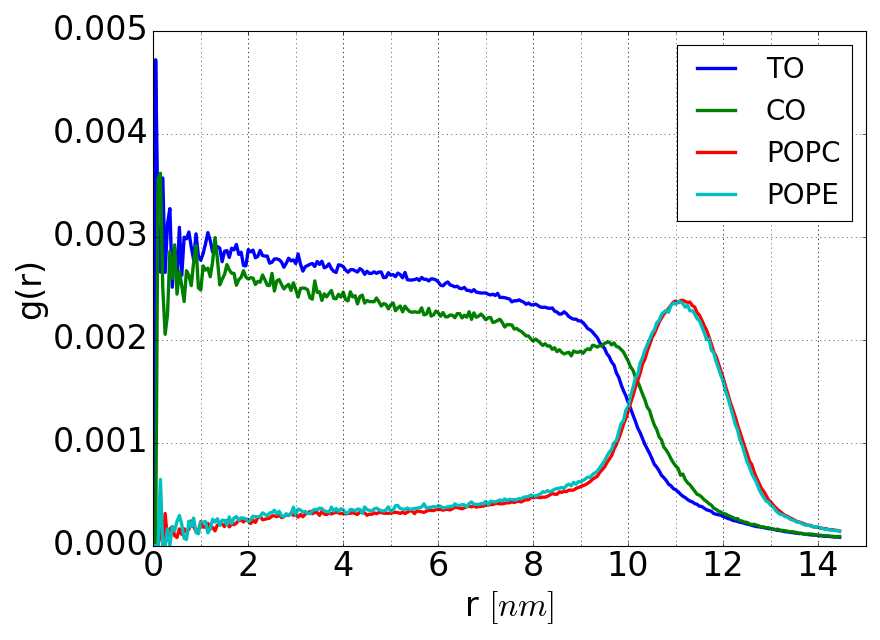

In [128]:
plot(rdfs)